Chat Bot with langgraph


In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [15]:
class State(TypedDict):
    messages :Annotated[list,add_messages]


graph_builder = StateGraph(State)

In [8]:
import os

In [7]:
from dotenv import load_dotenv

In [9]:
load_dotenv()

True

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")

In [9]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [10]:
graph_builder.add_node("llm_chatbot", chatbot)
graph_builder.add_edge(START, "llm_chatbot")
graph_builder.add_edge("llm_chatbot", END)


In [11]:
graph = graph_builder.compile()

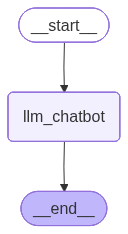

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"messages":"Hi"})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='b77fb0e3-c8a3-440b-96a1-87efc6e0437a'),
  AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.006841584, 'completion_tokens_details': None, 'prompt_time': 0.001599398, 'prompt_tokens_details': None, 'queue_time': 0.055829901, 'total_time': 0.008440982}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b82b0-9d02-7a81-9eea-0811e945e8f2-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})]}

In [16]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for val in event.values():
        print(val["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm here and ready to help you with any questions or topics you'd like to discuss. How can I assist you today?


In [44]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)
output  = tavily_tool.invoke("What is langgraph?")

In [19]:
output

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by model

In [28]:
def multiply(a:int, b:int) -> int:
    """Multiply a and b
    Args:
        a(int): first int
        b(int): second int
    Returns:
        int:output int
    """
    return a*b

In [ ]:
tools=[tavily_tool, multiply]
llm_with_tools = llm.bind_tools(tools)

In [22]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001FBDFC0E360>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FBE0122CF0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input sho

In [20]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

NameError: name 'Image' is not defined

In [24]:
output = graph.invoke({"messages":"What is recent AI news ?"})

In [26]:
output["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/deepseek-new-ai-training-models-scale-manifold-constrained-analysts-china-2026-1", "title": "China\'s DeepSeek kicked off 2026 with a new AI training method that analysts say is a \'breakthrough\' for scaling - Business Insider", "score": 0.97134733, "published_date": "Fri, 02 Jan 2026 07:10:41 GMT", "content": "# China\'s DeepSeek kicked off 2026 with a new AI training method that analysts say is a \'breakthrough\' for scaling. * China\'s DeepSeek has just published a new AI training method to scale models more easily. The Chinese AI startup published a research paper on Wednesday, describing a method to train large language models that could shape \\"the evolution of foundational models,\\" it said. DeepSeek combined various techniques to minimize the extra cost of training a model, Sun said. \\"The willingness to share important findings with t

In [27]:
for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is recent AI news ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4q8ne78mc)
 Call ID: 4q8ne78mc
  Args:
    query: recent AI news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/deepseek-new-ai-training-models-scale-manifold-constrained-analysts-china-2026-1", "title": "China's DeepSeek kicked off 2026 with a new AI training method that analysts say is a 'breakthrough' for scaling - Business Insider", "score": 0.97134733, "published_date": "Fri, 02 Jan 2026 07:10:41 GMT", "content": "# China's DeepSeek kicked off 2026 with a new AI training method that analysts say is a 'breakthrough' for scaling. * China's DeepSeek has just publi

ReAct Agent


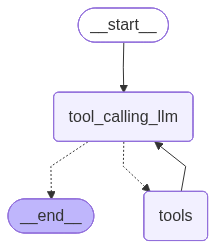

In [29]:
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
output = graph.invoke({"messages":"What is recent AI news ? and multiply 5 by 10"})


"The function returns null because the function 'multiply' returns the product of the two numbers, which is 50."

In [31]:
output["messages"]

[HumanMessage(content='What is recent AI news ? and multiply 5 by 10', additional_kwargs={}, response_metadata={}, id='76daa35f-119f-43a1-b648-d8ce63ec59c9'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g06bj67q8', 'function': {'arguments': '{"include_images":true,"query":"Recent AI news","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'a5n90k0ap', 'function': {'arguments': '{"a":5,"b":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 1748, 'total_tokens': 1802, 'completion_time': 0.072064194, 'completion_tokens_details': None, 'prompt_time': 0.106461213, 'prompt_tokens_details': None, 'queue_time': 0.053227717, 'total_time': 0.178525407}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b82cc-2

Adding Memory in Agents

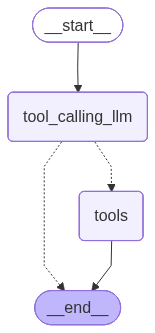

In [32]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
config = {"configurable":{"thread_id":1}}
response = graph.invoke({"messages":"Hi My name is Shravan"}, config=config)
response

{'messages': [HumanMessage(content='Hi My name is Shravan', additional_kwargs={}, response_metadata={}, id='23078868-79ce-48a6-8112-713feb22f19e'),
  AIMessage(content="Nice to meet you, Shravan. It's a pleasure to chat with you. What would you like to talk about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1741, 'total_tokens': 1767, 'completion_time': 0.052313473, 'completion_tokens_details': None, 'prompt_time': 0.279612448, 'prompt_tokens_details': None, 'queue_time': 0.062077472, 'total_time': 0.331925921}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b82d0-64a2-71f3-9c3a-28e04225f220-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1741, 'output_tokens': 26, 'total_tokens': 1767})]}

In [36]:
response["messages"][-1]

AIMessage(content="Nice to meet you, Shravan. It's a pleasure to chat with you. What would you like to talk about?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1741, 'total_tokens': 1767, 'completion_time': 0.052313473, 'completion_tokens_details': None, 'prompt_time': 0.279612448, 'prompt_tokens_details': None, 'queue_time': 0.062077472, 'total_time': 0.331925921}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b82d0-64a2-71f3-9c3a-28e04225f220-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 1741, 'output_tokens': 26, 'total_tokens': 1767})

In [38]:
response = graph.invoke({"messages":"Hi What is my name?"}, config=config)
response["messages"][-1]

ToolMessage(content='{"query": "your name is Shravan", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://momcozy.com/blogs/baby-names/shravan", "title": "Shravan Baby Name Meaning, Origin, Popularity Insights", "content": "The name derives from the Sanskrit word \'śravaṇa,\' meaning \'to hear\' or \'listening,\' highlighting the importance of attentive hearing in Hindu philosophy and", "score": 0.9988575, "raw_content": null}, {"url": "https://houseofzelena.com/blogs/baby-name/shravan?srsltid=AfmBOor3FPEuZ9cMmcD93aIHSPw8n0z2VfZWeK6pAnLnaiOi8io8cOs9", "title": "Shravan Name Meaning, Origin, Rashi, Numerology and ...", "content": "Shravan refers to a Hindu month and a prominent star. It also denotes a devoted son from the Ramayana. Gender Boy. Name Type Traditional.", "score": 0.9988575, "raw_content": null}], "response_time": 0.57, "request_id": "38857ee1-ee85-4824-ae64-6ad5852cc5c6"}', name='tavily_search', id='bc7bd6a9-33fc-41f4-b3ac-bf1b637bdeb1'

Streaming

In [39]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

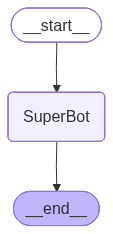

In [40]:
builder=StateGraph(State)
builder.add_node("SuperBot", superbot)
builder.add_edge(START,"SuperBot")
builder.add_edge("SuperBot", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
config = {"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"Hi My name is Shravan"}, config=config)
response

{'messages': [HumanMessage(content='Hi My name is Shravan', additional_kwargs={}, response_metadata={}, id='5d87172a-fd63-4e85-a5db-e21366e2af3e'),
  AIMessage(content="Hello Shravan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 41, 'total_tokens': 68, 'completion_time': 0.029294263, 'completion_tokens_details': None, 'prompt_time': 0.011596283, 'prompt_tokens_details': None, 'queue_time': 0.064777287, 'total_time': 0.040890546}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b82d4-7ff2-7373-96b5-574b9e97d8d5-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 41, 'output_tokens': 27, 'total_tokens': 68})]}

Human In The Loop

In [27]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [33]:
@tool
def human_assitance(query:str)->str:
    """Request assitance from a human."""
    human_response = interrupt({"query":query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assitance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

In [36]:
humann_loop_builder=StateGraph(State)
humann_loop_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
humann_loop_builder.add_node("tools", tool_node)
humann_loop_builder.add_conditional_edges("chatbot", tools_condition)
humann_loop_builder.add_edge(START,"chatbot")
humann_loop_builder.add_edge("tools","chatbot")
humann_loop_builder.add_edge("chatbot",END)


In [37]:
graph = humann_loop_builder.compile(checkpointer=memory)

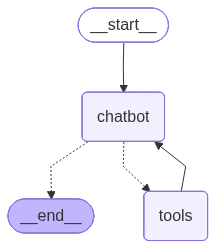

In [38]:
graph

In [41]:
user_input = "I need expert guidance and assitance to build AI agents"
config = {"configurable":{"thread_id":"1"}}
events = graph.stream({"messages":user_input},config=config,stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need expert guidance and assitance to build AI agents
================================== Ai Message ==================================
Tool Calls:
  human_assitance (204ary6mv)
 Call ID: 204ary6mv
  Args:
    query: expert guidance and assistance to build AI agents
================================== Ai Message ==================================
Tool Calls:
  human_assitance (204ary6mv)
 Call ID: 204ary6mv
  Args:
    query: expert guidance and assistance to build AI agents


In [42]:
human_res = ("We the experts are here to help! check langgraph to build agents")

human_command = Command(resume={"data":human_res})
events = graph.stream(human_command, config=config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assitance (204ary6mv)
 Call ID: 204ary6mv
  Args:
    query: expert guidance and assistance to build AI agents
================================= Tool Message =================================
Name: human_assitance

We the experts are here to help! check langgraph to build agents
================================== Ai Message ==================================
Tool Calls:
  tavily_search (ghs86vfzt)
 Call ID: ghs86vfzt
  Args:
    query: building AI agents
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building AI agents", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.fiddler.ai/articles/building-ai-agents", "title": "How to Build an AI Agent: A Step-by-Step Guide for Enterprises", "content": "## Step-by-Step to Building an AI Agent\